In [1]:
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm, trange
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from efficientnet_pytorch import EfficientNet
import pandas as pd

In [2]:
seed = 42
torch.cuda.get_device_name()

'Tesla T4'

In [3]:
labels = pd.read_csv("../input/SampleSubmission.csv")

In [4]:
BATCH_SIZE = 2**6
NUM_WORKERS = 4
LEARNING_RATE = 5e-5
LR_STEP = 2
LR_FACTOR = 0.2
NUM_EPOCHS = 16
LOG_FREQ = 50
TIME_LIMIT = 10 * 60 * 60
RESIZE = 350
WD = 0.003

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
torch.backends.cudnn.benchmark=True

# classes

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, mode):
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        transforms_list = [
            transforms.CenterCrop(RESIZE)
        ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomAffine(degrees=(0,180), translate=(0.1, 0.1),
                                            scale=(0.9, 1.1))
                ])
            ])

        transforms_list.extend([
            transforms.ToTensor(),
            #             transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                                   std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index):
        ''' Returns: tuple (sample, target) '''
        filename = self.df['Id'].values[index] if self.mode == 'test' else self.df['Filename'].values[index]

        directory = '../input/Test' if self.mode == 'test' else '../input/output_combined2'
        sample = Image.open(f'./{directory}/gb_12_{filename}')
        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df['Drscore'].values[index]

    def scaleRadius(self, img, scale):
        x = img[img.shape[0]//2,:,:].sum(1)
        r = (x > x.mean() / 10).sum() / 2
        s = scale * 1.0 / r
        return cv2.resize(img, (0, 0), fx=s, fy=s)

    def __len__(self):
        return self.df.shape[0]

In [8]:
def inference(data_loader, model):
    ''' Returns predictions and targets, if any. '''
    model.eval()

    all_predicts, all_targets = [], []

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.float().to(device))
            predicts = torch.round(output.flatten())
            predicts[predicts<0] = 0
            predicts[predicts>4] = 4
            all_predicts.append(predicts)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, targets

# model original

In [29]:
test_dataset = ImageDataset(labels, mode='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

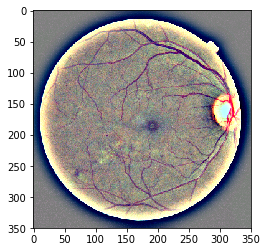

In [30]:
plt.imshow(test_dataset[0].permute(1, 2, 0))

In [31]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(device)
model = nn.DataParallel(model)

Using cache found in /home/scai/.cache/torch/hub/facebookresearch_WSL-Images_master


In [33]:
model.load_state_dict(torch.load("../model/resnet5e5_4data/resnet5e5_4data_9.ptm"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [34]:
predicts, targets = inference(test_loader, model)

100%|██████████| 63/63 [00:29<00:00,  2.44it/s]


In [35]:
labels['Expected'] = np.abs(predicts.cpu().numpy().astype(int))

In [36]:
labels.head()

,Id,Expected
0,test_image1.tif,3
1,test_image2.tif,1
2,test_image3.tif,0
3,test_image4.tif,3
4,test_image5.tif,0


In [28]:
labels.head()

,Id,Expected
0,test_image1.tif,2
1,test_image2.tif,0
2,test_image3.tif,0
3,test_image4.tif,2
4,test_image5.tif,0


In [37]:
labels.to_csv("../submissions/final_cv_resnet_5e5_reg_4data.csv", index=False)

In [30]:
labels.columns = ['Filename', 'Drscore']

labels.to_csv("../input/pseudolabeling/final_resnet_5e5_reg_3data_pl.csv", index=False)

# ORCNN

In [15]:
class ORCNN(nn.Module):
    def __init__(self):
        super(ORCNN, self).__init__()
        self.efnet = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5)
        self.efnet._fc = nn.Identity()
        self.or_layers = nn.ModuleList()
        for k in range(4):
            self.or_layers.append(nn.Linear(1792, 2))

    def forward(self, x, k):
        x = self.efnet(x)
        x = self.or_layers[k](x)
        
        return x

In [12]:
test_dataset = ImageDataset(labels, mode='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

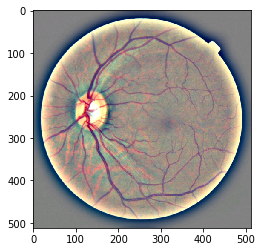

In [14]:
plt.imshow(test_dataset[1].permute(1, 2, 0))

In [16]:
model = ORCNN()

Loaded pretrained weights for efficientnet-b4


In [17]:
model = model.to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("../model/orcnn.ptm"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
predicts, confs, targets = inference_orcnn(test_loader, model)

In [21]:
labels['Expected'] = predicts.cpu().numpy()

In [22]:
labels.head()

,Id,Expected
0,test_image1.tif,2
1,test_image2.tif,0
2,test_image3.tif,1
3,test_image4.tif,2
4,test_image5.tif,0


In [23]:
labels.to_csv("../submissions/usyd_orcnn_partial_16.csv", index=False)


# TTA

In [9]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, mode):
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        transforms_list = [
            transforms.CenterCrop(RESIZE)
        ]

        transforms_list.extend([
            transforms.RandomHorizontalFlip(),
            transforms.RandomChoice([
                transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                transforms.RandomAffine(degrees=(0, 180), translate=(0.1, 0.1),
                                        scale=(0.9, 1.1))
            ])
        ])

        transforms_list.extend([
            transforms.ToTensor()
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index):
        ''' Returns: tuple (sample, target) '''
        filename = self.df['Id'].values[index] if self.mode == 'test' else self.df['Filename'].values[index]

        directory = '../input/Test' if self.mode == 'test' else '../input/output_combined2'
        sample = Image.open(f'./{directory}/gb_12_{filename}')
        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df['Drscore'].values[index]

    def __len__(self):
        return self.df.shape[0]

In [10]:
def inference(data_loader, model):
    ''' Returns predictions and targets, if any. '''
    model.eval()

    all_predicts, all_targets = [], []

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.float().to(device))
            all_predicts.append(output)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, targets

In [13]:
test_dataset = ImageDataset(labels, mode='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

In [14]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("../model/resnet5e5_4data/resnet5e5_4data_9.ptm"))

Using cache found in /home/scai/.cache/torch/hub/facebookresearch_WSL-Images_master


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
all_predicts = []
for i in trange(100):
    predicts, targets = inference(test_loader, model)
    all_predicts.append(predicts.cpu().numpy().flatten())

100%|██████████| 100/100 [57:33<00:00, 34.44s/it]


In [16]:
all_predicts = np.asarray(all_predicts)

all_predicts = np.mean(all_predicts, axis=0)

all_predicts = np.round(all_predicts)

all_predicts = all_predicts.astype(int)

In [28]:
all_predicts[all_predicts>4] = 4
all_predicts[all_predicts<0] = 0

In [29]:
labels['Expected'] = all_predicts

In [30]:
labels.head()

,Id,Expected
0,test_image1.tif,3
1,test_image2.tif,0
2,test_image3.tif,0
3,test_image4.tif,2
4,test_image5.tif,0


In [31]:
labels.to_csv("../submissions/final_cv_resnet_5e5_reg_4data_tta.csv", index=False)